# Waveform classification using calibration files in DS1

This notebook attempts to use a simple sequential model in Keras to attempt to do a binary classification of single and multi-site waveforms. The analysis is only performed on one detector (Channel 626) which has the most accurate transfer functions for simulations.

The waveforms were pre-processed before saving to a Pandas Dataframe. To normalize the inputs, first the amplitudes of all the waveforms were normalized to one, then the 50% rise-time is found and 400 samples before and after the 50% mark are saved to center each waveform. 

In [1]:
# Only uses Ch626 in DS1
# Import basic things
import numpy as np
import pandas as pd
import glob
import keras
from keras import models
from keras import layers

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid') # Set style so background is white
sns.set_context('talk') # Set context to talk to make axis labels larger

Using TensorFlow backend.


In [2]:
# Read in files -- the files are stored as Pandas DataFrames
extDir = '/Users/brianzhu/project/Pandas/cal-skim'
sigFiles = glob.glob('%s/waveSkimDS1_run*.h5' % extDir)
dfSigFull = pd.DataFrame()
sigList = []
# Too many files in list, just use first 100
for f in sigFiles[:100]:
    try:
        dfDummy = pd.read_hdf(f,'skimTree')
        sigList.append(dfDummy)
    except:
        print ("%s is broken"%(f))
print ('Loaded %d files'%(len(sigList)))
dfSigFull = pd.concat(sigList)
# Prints out first 5 lines of the DataFrame
# Each sample of the waveform is saved as wave# (eg: the 1st sample is wave0)
# Some basic parameters are saved like channel, run, trapENFCal, avse, and dcr99
dfSigFull.head()

Loaded 100 files


,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave0,wave1,...,wave90,wave91,wave92,wave93,wave94,wave95,wave96,wave97,wave98,wave99
0,1.0,-83.759123,626.0,-0.001324,1.0,10004.0,2613.018297,6332.061195,-0.000197,-0.000041,...,-0.000354,0.000116,-0.000354,0.000272,0.000272,0.000116,-0.000354,-0.000354,0.000116,-0.000197
1,1.0,0.742406,626.0,-0.000348,1.0,10004.0,166.454222,6297.228554,-0.004386,-0.001960,...,0.000466,-0.001960,-0.001960,-0.009238,-0.009238,-0.001960,-0.004386,-0.001960,-0.001960,0.002892
2,1.0,0.196491,626.0,-0.000298,1.0,10004.0,143.571530,6241.195025,-0.007265,0.001176,...,0.003990,0.003990,0.003990,0.001176,-0.001638,-0.007265,-0.004451,-0.001638,-0.004451,-0.001638
3,1.0,-15.399226,626.0,-0.000548,1.0,10004.0,693.177898,6280.520079,0.000825,0.000825,...,-0.000941,-0.000352,-0.000941,-0.000352,-0.000941,-0.000352,0.001414,-0.000352,0.000237,-0.000352
4,1.0,-0.430794,626.0,-0.000240,1.0,10004.0,276.364021,6267.693007,-0.000815,0.000672,...,0.002159,0.003646,-0.002302,0.000672,-0.000815,-0.002302,-0.000815,-0.005276,-0.002302,-0.002302


In [3]:
# Looking at the shape of the dataframe as well as the end
# The shape shows the # of events vs # of parameters
print dfSigFull.shape
dfSigFull.tail()

(960467, 808)


,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave0,wave1,...,wave90,wave91,wave92,wave93,wave94,wave95,wave96,wave97,wave98,wave99
9027,1.0,0.165817,626.0,-0.000189,1.0,12660.0,929.989648,6355.028586,0.000064,-0.000372,...,0.000500,-0.001245,-0.000808,-0.000808,-0.001245,0.000064,-0.001245,-0.000372,0.000064,-0.000372
9028,1.0,-2.729652,626.0,-0.000117,1.0,12660.0,323.432646,6330.954804,0.003613,0.002361,...,-0.000143,-0.000143,-0.001394,-0.001394,-0.002646,-0.002646,0.002361,0.002361,0.003613,0.002361
9029,1.0,-0.521936,626.0,-0.000273,1.0,12660.0,1622.793457,6350.841214,-0.000613,-0.000113,...,0.001387,0.000637,0.000637,0.000137,-0.000113,0.000137,-0.000363,0.000387,-0.000363,-0.000113
9030,1.0,0.717482,626.0,-0.000201,1.0,12660.0,107.884461,6233.485087,-0.005536,-0.005536,...,0.001885,-0.005536,-0.012957,-0.005536,0.001885,-0.001826,-0.005536,-0.016667,-0.005536,0.005595
9031,1.0,0.299821,626.0,-0.000246,1.0,12660.0,113.418357,6239.638557,0.001650,-0.008971,...,0.005190,-0.008971,0.001650,0.001650,0.005190,0.001650,0.005190,-0.001890,0.001650,-0.005431


In [4]:
# The index (1st column) gets duplicated -- this is because the index resets for every file
# We can reset the index column -- this assures a unique index value for each event
dfSigReset = dfSigFull.reset_index()

# Check indices are correct now -- the previous index column is now called "index"
# We can rename it if it's confusing
print dfSigReset.shape[0]
dfSigReset.tail()

960467


,index,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave0,...,wave90,wave91,wave92,wave93,wave94,wave95,wave96,wave97,wave98,wave99
960462,9027,1.0,0.165817,626.0,-0.000189,1.0,12660.0,929.989648,6355.028586,0.000064,...,0.000500,-0.001245,-0.000808,-0.000808,-0.001245,0.000064,-0.001245,-0.000372,0.000064,-0.000372
960463,9028,1.0,-2.729652,626.0,-0.000117,1.0,12660.0,323.432646,6330.954804,0.003613,...,-0.000143,-0.000143,-0.001394,-0.001394,-0.002646,-0.002646,0.002361,0.002361,0.003613,0.002361
960464,9029,1.0,-0.521936,626.0,-0.000273,1.0,12660.0,1622.793457,6350.841214,-0.000613,...,0.001387,0.000637,0.000637,0.000137,-0.000113,0.000137,-0.000363,0.000387,-0.000363,-0.000113
960465,9030,1.0,0.717482,626.0,-0.000201,1.0,12660.0,107.884461,6233.485087,-0.005536,...,0.001885,-0.005536,-0.012957,-0.005536,0.001885,-0.001826,-0.005536,-0.016667,-0.005536,0.005595
960466,9031,1.0,0.299821,626.0,-0.000246,1.0,12660.0,113.418357,6239.638557,0.001650,...,0.005190,-0.008971,0.001650,0.001650,0.005190,0.001650,0.005190,-0.001890,0.001650,-0.005431


In [5]:
# Make an array for features for training
# This will be used for training while keeping the other data
wave_cols = ['wave'+str(i) for i in range(300,500)] # For Waveform -- focus exclusively on the rising edge

# Since I'll be doing categorization in keras, create two categories
truth_cols = ['Multi', 'Single']
print truth_cols
print len(wave_cols) # Length should be 200

['Multi', 'Single']
200


# Set-up training data
Clean up data as well as create basic training data by creating two dataframes. The first dataframe cuts around the single-escape peak (multi-site event) in energy and uses avse<=-2. The second dataframe cuts around the double escape peak and uses avse>-1.

Then create two columns named 'Multi' and 'Single' for categorization

In [6]:
dfMulti = dfSigReset.query('2099<trapENFCal<2109 and avse<=-2')
dfSingle = dfSigReset.query('1588<trapENFCal<1598 and avse>-1')

dfMulti.loc[:,'Multi'] = 1
dfMulti.loc[:,'Single'] = 0
dfSingle.loc[:,'Multi'] = 0
dfSingle.loc[:,'Single'] = 1

# Check the new dataframes are correct
print dfMulti.shape
print dfSingle.shape
dfMulti.head()

/Users/brianzhu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/brianzhu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(2678, 811)
(1524, 811)


,index,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave0,...,wave92,wave93,wave94,wave95,wave96,wave97,wave98,wave99,Multi,Single
259,259,1.0,-14.929873,626.0,-0.001179,1.0,10004.0,2103.647990,6331.329536,-0.000176,...,-0.000176,-0.000176,0.000212,-0.000564,0.000600,0.000212,0.000018,0.000212,1,0
576,576,1.0,-5.394409,626.0,-0.001293,1.0,10004.0,2108.004759,6339.520086,0.000224,...,-0.000357,-0.000743,-0.000163,0.000030,0.000610,0.000224,0.000030,0.000417,1,0
923,923,1.0,-7.317523,626.0,-0.001031,1.0,10004.0,2101.621986,6326.842415,0.000168,...,-0.000220,-0.000026,0.000168,-0.000026,-0.000414,0.000362,-0.000026,0.000362,1,0
1105,1105,1.0,-23.343226,626.0,-0.001274,1.0,10004.0,2104.167659,6288.618099,-0.000222,...,0.000166,-0.000222,-0.000416,-0.000416,-0.000222,0.000748,-0.000028,0.000166,1,0
1138,1138,1.0,-17.692985,626.0,-0.000806,1.0,10004.0,2106.690634,6317.853908,0.000060,...,-0.000137,0.000257,0.000454,0.000060,-0.000137,-0.000531,-0.000531,-0.000334,1,0


Now draw some waveforms from each dataframe to make sure they look correct. Randomly sample the index to select the waveforms drawn.

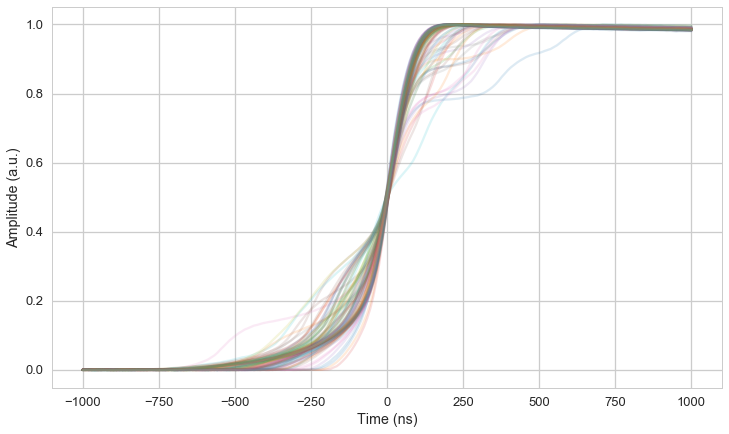

In [7]:
waveTS = np.linspace(-1000, len(wave_cols)*10-1000, len(wave_cols))

rndperm1 = np.random.permutation(dfMulti.index.values)

fig1 = plt.figure(figsize=(12,7))
for i in range(0,100):
    plt.plot(waveTS, dfMulti.loc[rndperm1[i],wave_cols].values, alpha=0.15)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (a.u.)')

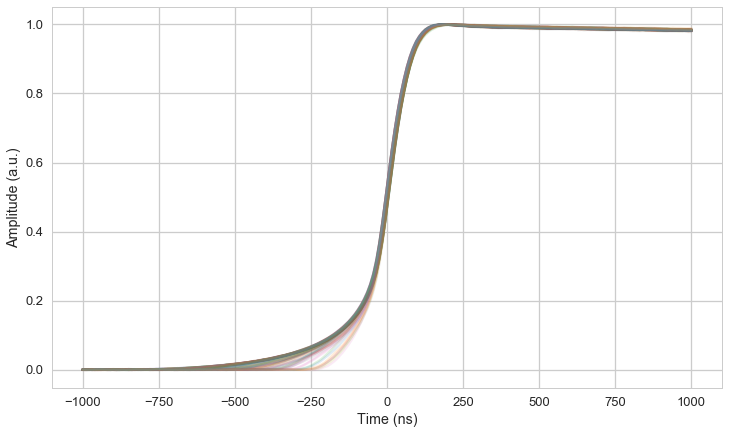

In [8]:
rndperm2 = np.random.permutation(dfSingle.index.values)

fig2 = plt.figure(figsize=(12,7))
for i in range(0,100):
    plt.plot(waveTS, dfSingle.loc[rndperm2[i],wave_cols].values, alpha=0.15)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (a.u.)')

# Split up training data for testing
First combine both dataframes into one total dataframe, then use sklearn's built-in function to split up the data. Create a split of 10% of the data for evaluation, then split off 90% of the development dataset to use for training and the other 10% for validation.

In [9]:
from sklearn.model_selection import train_test_split

TotalDF = pd.concat([dfSingle,dfMulti])
print TotalDF.head()
print (TotalDF.shape)

# Split it twice, first split creates development (with 90% of data) and evaluation set (10%), then split the development data 
# 2nd split is for training sample and test sample
DF_dev, DF_eval = train_test_split(TotalDF, test_size=0.10, random_state=42)
DF_train, DF_test = train_test_split(DF_dev, test_size=0.10, random_state=492)

# Print out how many events are left by the shape
print(DF_dev.shape[0], DF_eval.shape[0], DF_train.shape[0], DF_test.shape[0])

       index    C      avse  channel     dcr99  mHL      run   trapENFCal  \
1487    1487  1.0  1.942625    626.0 -0.000856  1.0  10004.0  1592.653134   
6039     460  1.0 -0.934989    626.0 -0.000953  1.0  10005.0  1592.039042   
14583   2386  1.0  0.894281    626.0 -0.000922  1.0  10006.0  1595.742119   
18551   3457  1.0 -0.670211    626.0 -0.001021  1.0  10006.0  1591.490338   
20857   1557  1.0 -0.754701    626.0 -0.000918  1.0  10007.0  1591.251696   

       triggerTrapt0     wave0   ...      wave92    wave93    wave94  \
1487     6350.227974 -0.000566   ...    0.000968  0.000712  0.000201   
6039     6339.780355 -0.000217   ...    0.000039  0.000039  0.000039   
14583    6343.181754  0.000205   ...   -0.000306  0.000205  0.000205   
18551    6325.292933 -0.000356   ...   -0.000356  0.000667 -0.000356   
20857    6318.958691  0.000059   ...   -0.000197  0.000059 -0.000197   

         wave95    wave96    wave97    wave98    wave99  Multi  Single  
1487   0.000457 -0.000566 -0.00

In [10]:
# Look at the forms of the matrices, make sure everything looks fine
print DF_train.loc[:,wave_cols].values.shape
# Looks like need to format the Truth column, probably should add 2 columns (Multi and Single)
print DF_train.loc[:,truth_cols].values.shape


(3402, 200)
(3402, 2)


In [11]:
# Try to train using keras now
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(200,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [12]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [13]:
history = model.fit(DF_train.loc[:,wave_cols].values,
                   DF_train.loc[:,truth_cols].values,
                   epochs=50,
                   batch_size=512,
                   validation_data=(DF_test.loc[:,wave_cols].values, DF_test.loc[:,truth_cols].values))

Train on 3402 samples, validate on 379 samples
Epoch 1/50
3402/3402 [==============================] - 0s - loss: 0.7019 - acc: 0.5888 - val_loss: 0.6582 - val_acc: 0.6121
Epoch 2/50
3402/3402 [==============================] - 0s - loss: 0.6429 - acc: 0.6434 - val_loss: 0.6572 - val_acc: 0.6121
Epoch 3/50
3402/3402 [==============================] - 0s - loss: 0.6509 - acc: 0.6581 - val_loss: 0.6606 - val_acc: 0.6121
Epoch 4/50
3402/3402 [==============================] - 0s - loss: 0.6475 - acc: 0.6529 - val_loss: 0.6439 - val_acc: 0.6121
Epoch 5/50
3402/3402 [==============================] - 0s - loss: 0.6308 - acc: 0.6470 - val_loss: 0.6541 - val_acc: 0.6121
Epoch 6/50
3402/3402 [==============================] - 0s - loss: 0.6357 - acc: 0.6708 - val_loss: 0.6380 - val_acc: 0.6253
Epoch 7/50
3402/3402 [==============================] - 0s - loss: 0.6108 - acc: 0.6470 - val_loss: 0.6179 - val_acc: 0.6306
Epoch 8/50
3402/3402 [==============================] - 0s - loss: 0.6449 - ac

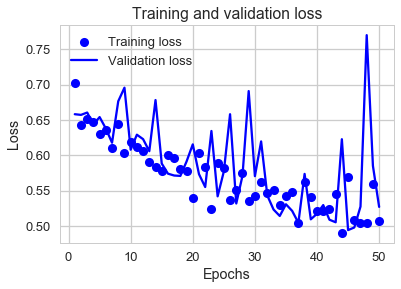

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

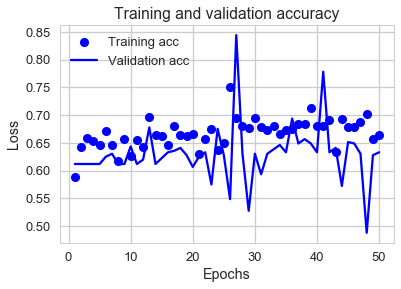

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()